### Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import sklearn
import lightgbm as lgb
import shap
import xgboost
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


c:\Users\Lulock\anaconda3\envs\xai\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### California Housing Dataset 

In [2]:
cal_data = fetch_california_housing()

In [3]:
print(cal_data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
X = cal_data.data
y = cal_data.target 
cal_features = cal_data.feature_names

cal_df = pd.concat((pd.DataFrame(X, columns = cal_features ),
                    pd.DataFrame({'MedianHouseVal': y})), axis=1)

In [5]:
cal_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [6]:
# Split dataset into training and testing data. 20% for testing, 80% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [7]:
# Train an XGBoost model
xgb_regressor = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators =500)
xgb_regressor.fit(X_train, y_train) # fit to training data

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [8]:
# Mean Squared Error
def compute_mse(predictions, true_labels):
    return np.mean((predictions - true_labels)**2)

In [9]:
test_predictions = np.squeeze(xgb_regressor.predict(X_test)) # use np.squeeze() to remove all dimensions of size 1 from the NumPy array
mse_test = compute_mse(test_predictions, y_test)
print(f'the Root Mean Squared Error of this XGBoost model is {np.sqrt(mse_test)}')

the Root Mean Squared Error of this XGBoost model is 0.47806185469522344


### Time to Explain using SHAP

In [10]:
explainer = shap.Explainer(xgb_regressor, feature_names=cal_features) # compute feature attributions using SHAP
shap_values = explainer(X_test) 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [11]:
np.round(np.abs(shap_values.values.sum(1) + explainer.expected_value - test_predictions).max())

0.0

In [12]:
print(f'Shap values are of type {type(shap_values)} and are of shape {shap_values.shape} which should be same as Test set {X_test.shape}')

Shap values are of type <class 'shap._explanation.Explanation'> and are of shape (4128, 8) which should be same as Test set (4128, 8)


In [13]:
shap.initjs() # initialising SHAP javascript module for js-based notebook viz in SHAP
shap.plots.force(shap_values[:,"MedInc"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


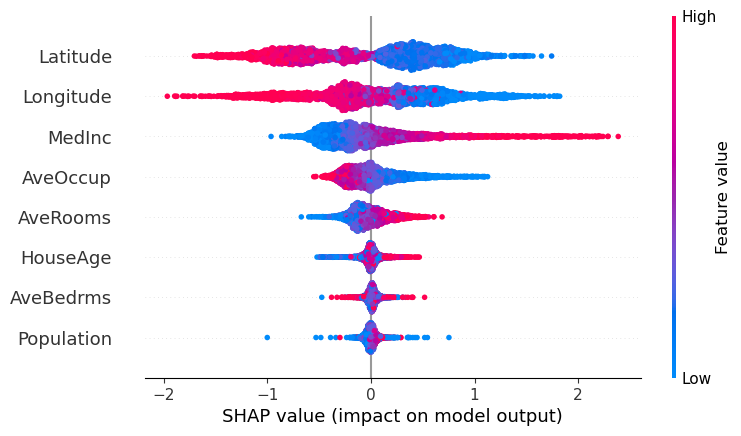

In [14]:
shap.plots.beeswarm(shap_values)
# shap.summary_plot(shap_values, X_test)

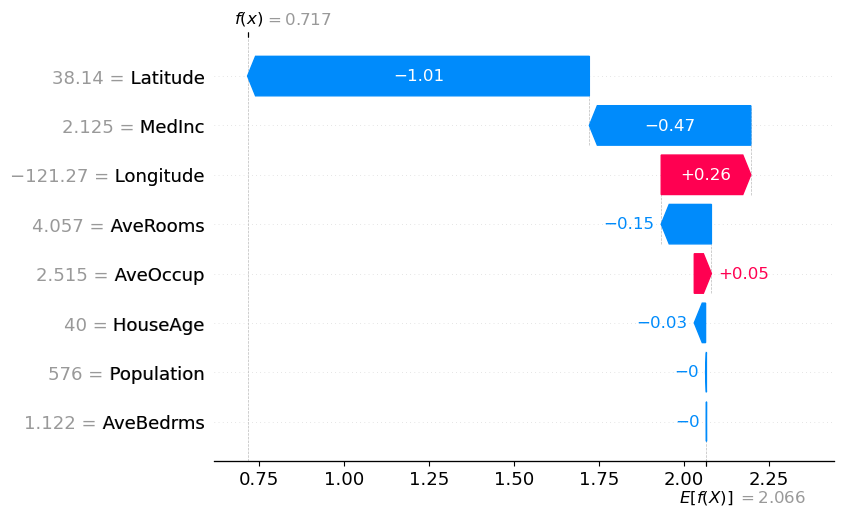

In [15]:
shap.plots.waterfall(shap_values[0])

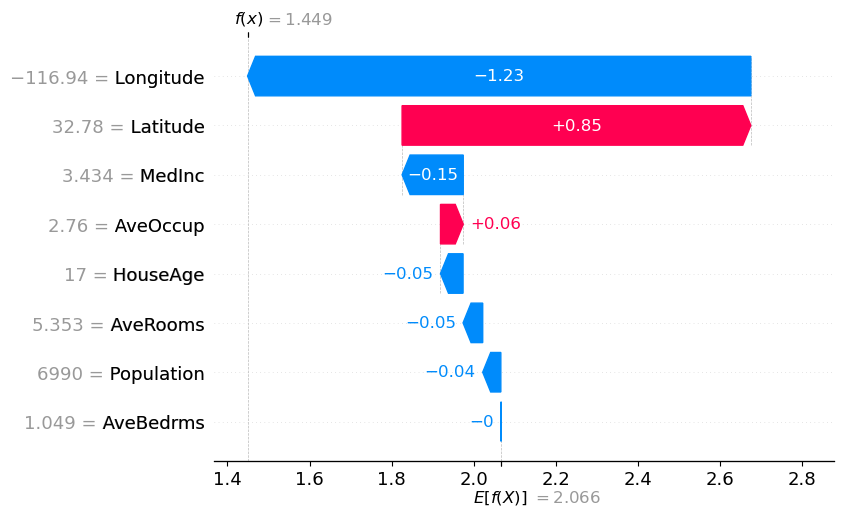

In [16]:
shap.plots.waterfall(shap_values[1])

In [17]:
shap_first_instance = shap_values[1]
shap_first_instance_values = shap_first_instance.values
print(f'Predicted value: {shap_first_instance.base_values + sum(shap_first_instance_values)}\n') # f(x) for this instance = E[f(x) + sum of all feature attributions]
print(f'Baseline: {shap_first_instance.base_values}\n') # E[f(x)] average prediction over whole test set

ordered_attr = np.argsort(-np.abs(shap_first_instance_values)) # order by descending val
for i in range(len(shap_first_instance_values)):
    print(f'{shap_values.feature_names[ordered_attr[i]]}: {shap_first_instance_values[ordered_attr[i]]}')

Predicted value: 1.449112224043347

Baseline: 2.066380500793457

Longitude: -1.225342869758606
Latitude: 0.8490761518478394
MedInc: -0.14891794323921204
AveOccup: 0.055417437106370926
HouseAge: -0.054946642369031906
AveRooms: -0.047845616936683655
Population: -0.04414602741599083
AveBedrms: -0.0005627659847959876
